In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM

import tensorflow as tf
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils import plot_model
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
# set seed to reproduce similar results
np.random.seed(0)

In [2]:
from google.colab import drive   # 코랩 드라이브와 연동
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Data_path= "/content/drive/MyDrive/gachon4-2/deeplearning/week4/UCI HAR Dataset"

In [4]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [5]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

In [6]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = os.path.join(prefix, group, 'Inertial Signals')
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['/total_acc_x_'+group+'.txt', '/total_acc_y_'+group+'.txt', '/total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['/body_acc_x_'+group+'.txt', '/body_acc_y_'+group+'.txt', '/body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['/body_gyro_x_'+group+'.txt', '/body_gyro_y_'+group+'.txt', '/body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(os.path.join(prefix, group,'y_'+group+'.txt'))
	return X, y

In [7]:
# load the dataset, returns train and test X and y elements
def load_dataset():
    # load all train
    trainX, trainy = load_dataset_group('train',  Data_path)
    # load all test
    testX, testy = load_dataset_group('test', Data_path)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy


In [8]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [9]:

# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()


(470528, 9)


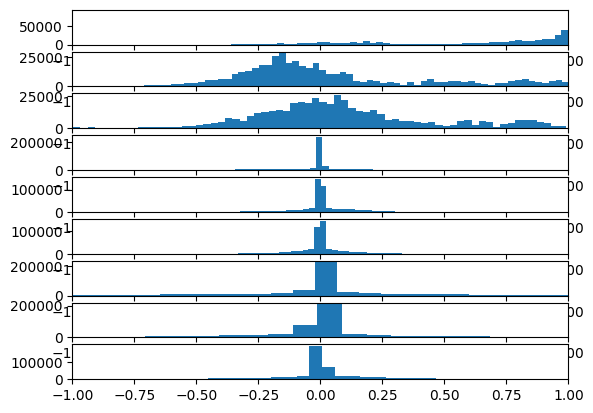

In [10]:
# plot distributions
plot_distributions(trainX)

In [12]:

## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

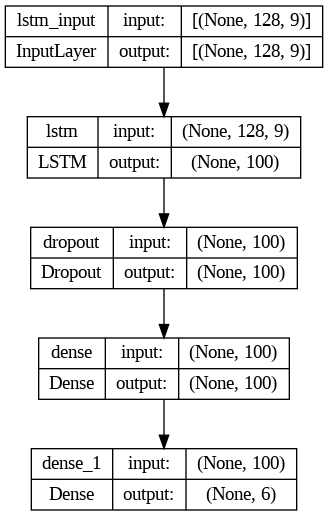

In [13]:

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [15]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)


Epoch 1/10
92/92 [==============================] - 11s 24ms/step - loss: 1.2759 - accuracy: 0.4549 - val_loss: 1.0333 - val_accuracy: 0.6247
Epoch 2/10
92/92 [==============================] - 1s 15ms/step - loss: 0.9653 - accuracy: 0.5979 - val_loss: 0.9592 - val_accuracy: 0.6288
Epoch 3/10
92/92 [==============================] - 2s 16ms/step - loss: 0.8323 - accuracy: 0.6339 - val_loss: 0.9177 - val_accuracy: 0.6329
Epoch 4/10
92/92 [==============================] - 1s 13ms/step - loss: 0.7168 - accuracy: 0.6992 - val_loss: 0.8075 - val_accuracy: 0.7090
Epoch 5/10
92/92 [==============================] - 2s 26ms/step - loss: 0.6783 - accuracy: 0.7215 - val_loss: 0.7215 - val_accuracy: 0.7254
Epoch 6/10
92/92 [==============================] - 1s 11ms/step - loss: 0.5428 - accuracy: 0.7994 - val_loss: 0.7552 - val_accuracy: 0.7736
Epoch 7/10
92/92 [==============================] - 1s 9ms/step - loss: 0.4464 - accuracy: 0.8427 - val_loss: 0.6937 - val_accuracy: 0.7988
Epoch 8/10
92

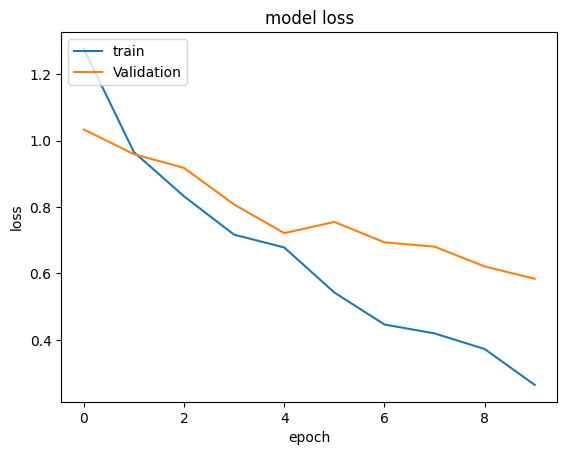

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')


In [17]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.8530709147453308
93/93 [==============================] - 1s 4ms/step


In [18]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[443  27  26   0   0   0]
 [ 40 375  56   0   0   0]
 [ 25  24 371   0   0   0]
 [  0   1   0 408  82   0]
 [  4   8   1  96 423   0]
 [  0  27  16   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.87      0.89      0.88       496
           2       0.81      0.80      0.80       471
           3       0.79      0.88      0.83       420
           4       0.81      0.83      0.82       491
           5       0.84      0.80      0.82       532
           6       1.00      0.92      0.96       537

    accuracy                           0.85      2947
   macro avg       0.85      0.85      0.85      2947
weighted avg       0.86      0.85      0.85      2947



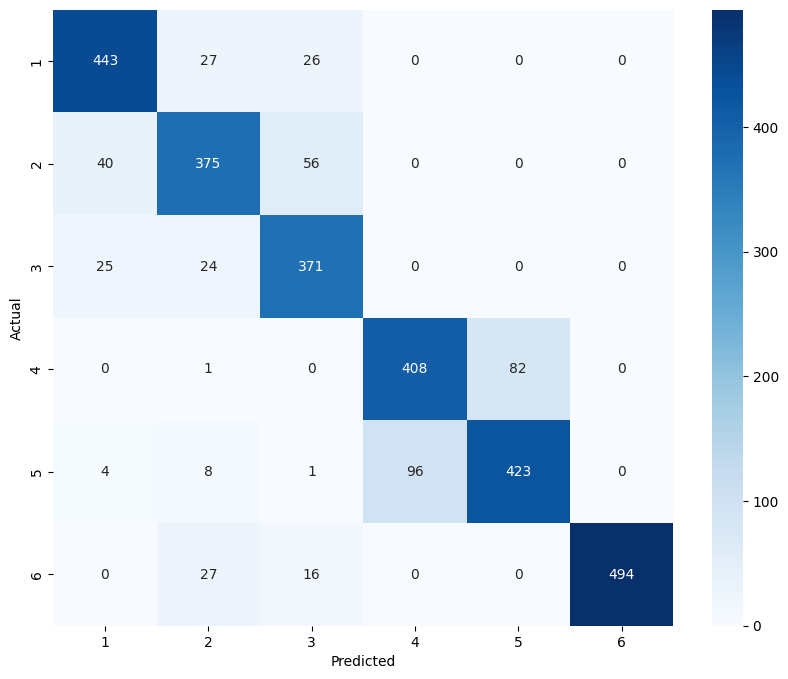

In [19]:

classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

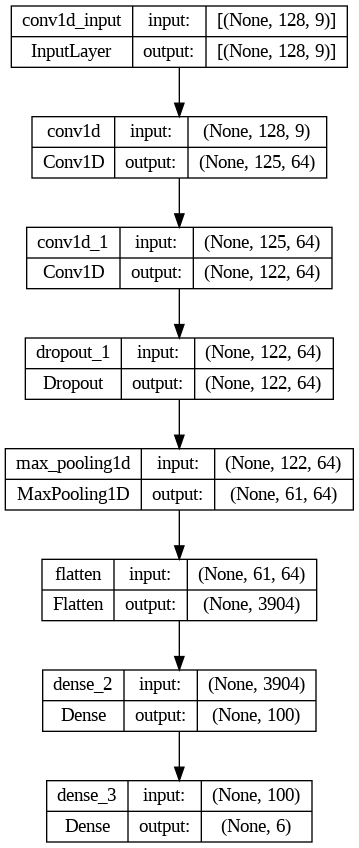

In [20]:

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [22]:
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)


Epoch 1/20
92/92 [==============================] - 10s 14ms/step - loss: 0.4705 - accuracy: 0.8099 - val_loss: 0.4229 - val_accuracy: 0.8865
Epoch 2/20
92/92 [==============================] - 0s 5ms/step - loss: 0.1536 - accuracy: 0.9415 - val_loss: 0.3378 - val_accuracy: 0.9014
Epoch 3/20
92/92 [==============================] - 0s 5ms/step - loss: 0.1200 - accuracy: 0.9529 - val_loss: 0.3562 - val_accuracy: 0.9096
Epoch 4/20
92/92 [==============================] - 0s 5ms/step - loss: 0.0943 - accuracy: 0.9580 - val_loss: 0.3455 - val_accuracy: 0.9021
Epoch 5/20
92/92 [==============================] - 0s 5ms/step - loss: 0.0922 - accuracy: 0.9594 - val_loss: 0.3702 - val_accuracy: 0.8804
Epoch 6/20
92/92 [==============================] - 0s 5ms/step - loss: 0.0885 - accuracy: 0.9621 - val_loss: 0.3995 - val_accuracy: 0.9007
Epoch 7/20
92/92 [==============================] - 0s 5ms/step - loss: 0.0812 - accuracy: 0.9650 - val_loss: 0.4431 - val_accuracy: 0.9007
Epoch 8/20
92/92 [

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')


In [23]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)


Accuracy of the CNN model 0.9090600609779358
93/93 [==============================] - 0s 2ms/step


**** Confusion Matrix ****
[[458   7  31   0   0   0]
 [  1 443  27   0   0   0]
 [  1   4 415   0   0   0]
 [  0   7   0 411  73   0]
 [  1   3   0  86 442   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.99      0.92      0.96       496
           2       0.90      0.94      0.92       471
           3       0.88      0.99      0.93       420
           4       0.83      0.84      0.83       491
           5       0.86      0.83      0.84       532
           6       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



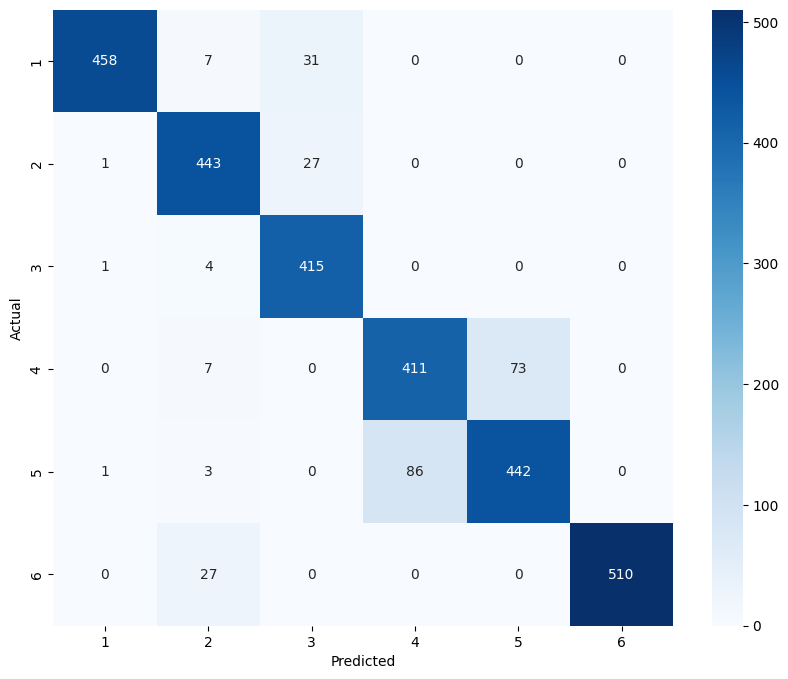

In [24]:
display_results(testy,predictions,classNames)


In [25]:
Data_path

'/content/drive/MyDrive/gachon4-2/deeplearning/week4/UCI HAR Dataset'

In [28]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):

    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv(os.path.join(Data_path, 'features.txt'),sep='\s+',
                        header=None,names=['column_index','column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv(os.path.join(Data_path, 'train/X_train.txt'),sep='\s+', names=feature_name )
    X_test = pd.read_csv(os.path.join(Data_path, 'test/X_test.txt'),sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv(os.path.join(Data_path, 'train/y_train.txt'),sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv(os.path.join(Data_path, 'test/y_test.txt'),sep='\s+',header=None,names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

print("## 학습 피처 데이터 정보 ##")
print(X_train.info())

## 학습 피처 데이터 정보 ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [30]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


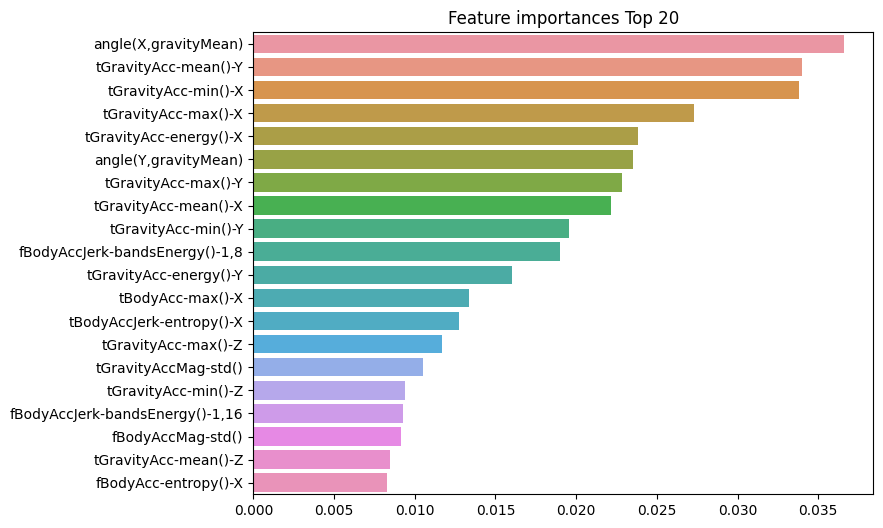

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [40]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('SVM 정확도: {0:.4f}'.format(accuracy))

SVM 정확도: 0.9403


In [38]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('DecisionTree 정확도: {0:.4f}'.format(accuracy))

DecisionTree 정확도: 0.8595


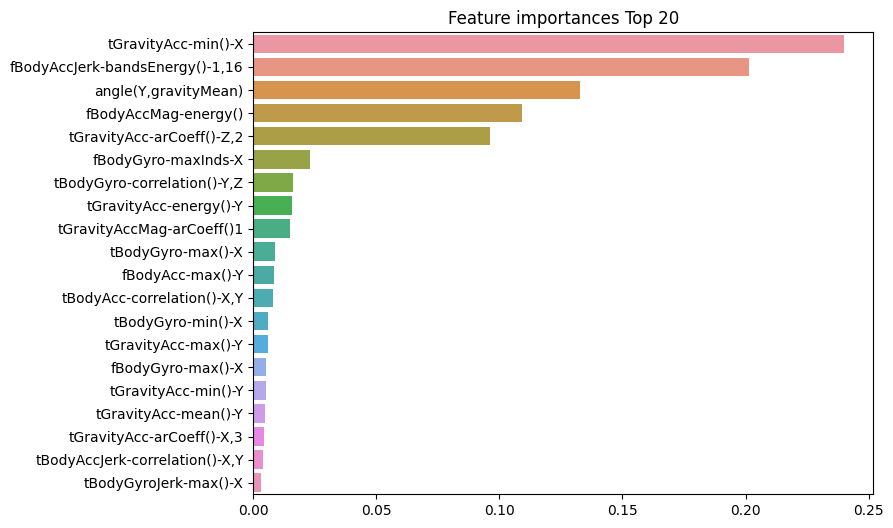

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [43]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('logreg 정확도: {0:.4f}'.format(accuracy))

logreg 정확도: 0.9552
